In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from astroNN.nn.layers import MCDropout
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('data/jla.csv')
z = df.values[:,0]
y = df.values[:,1:]

In [3]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [4]:
# r = scalerz.transform(z.reshape(-1, 1))
# predh = model.predict(r)

In [5]:
ffnn_do = tf.keras.models.load_model('models/09032022_MCDO_V2/FFNN_MCDO3.h5', custom_objects={'MCDropout': MCDropout})

2022-05-13 10:51:46.408037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 10:51:46.409329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/isidro/cfitsio/lib:/home/isidro/MultiNest/lib:/home/isidro/cuba/:LD_LIBRARY_PATH:/home/isidro/.openmpi/lib/:/lib
2022-05-13 10:51:46.409637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/isidro/cfitsio/lib:/home/isidro/MultiNest/lib:/home/isidro/cuba/:LD_LIBRARY_PATH:/home/isidro/.openmpi/lib/:/lib
2022-05-13 10:51:46.409856: W tensorflow/stream_ex

In [7]:
test_batch_size = len(z)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 3))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = ffnn_do.predict(z)
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)

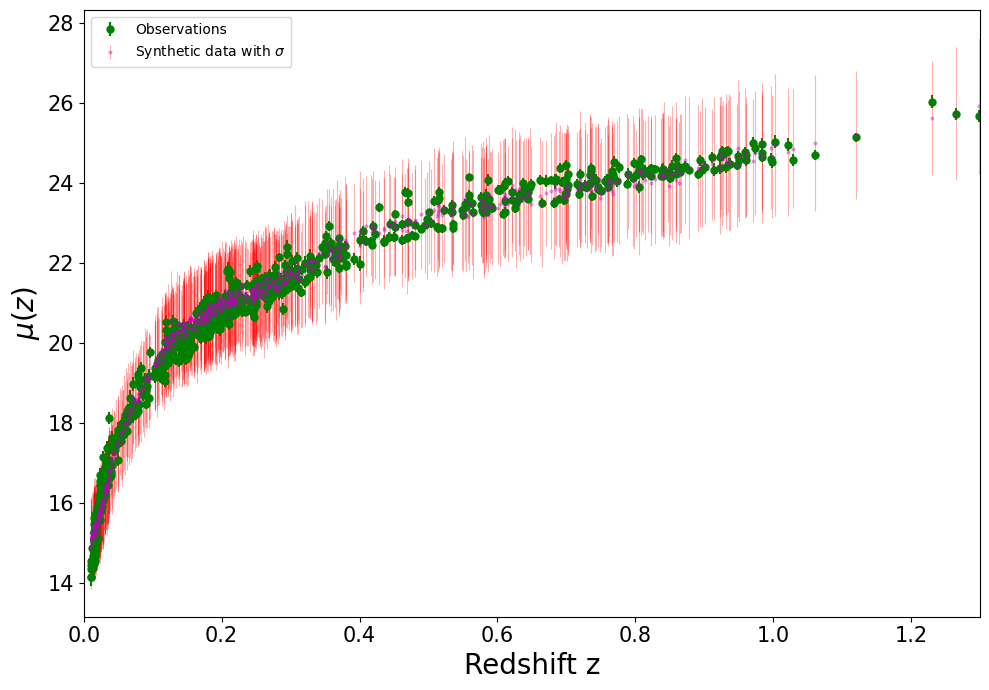

In [15]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
# plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['zcmb'], df['mb'], df['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(scalerz.inverse_transform(z), prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,2)
plt.xlim(0, 1.3)
# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

In [16]:
# save fake data
mocky_mcdo = np.concatenate((prediction_mc_dropout[:,0].reshape(-1,1), sigma.reshape(-1,1)), axis=1)
mockmuz_ffnn_mcdo = np.concatenate((z.reshape(-1,1), mocky_mcdo), axis=1)
np.savetxt("sn_mcdo_mock.dat",mockmuz_ffnn_mcdo, delimiter=" ")